In [1]:
import pandas as pd
import numpy as np
import os
import io
import boto3
import sagemaker

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

sagemaker.__version__

'1.72.0'

In [2]:
# DATA (most complicated way to get a csv fromm a s3 bucket)

s3_client = boto3.client('s3')
bucket_name='aws-ml-blog-sagemaker-census-segmentation'

# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
file_name=files[0]

data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

data_body = data_object["Body"].read()

# read in bytes data
data_stream = io.BytesIO(data_body)

# create a dataframe
counties_df = pd.read_csv(data_stream, header=0, delimiter=",") 
counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [3]:
# Preprocessing I

clean_counties_df = counties_df.dropna()
clean_counties_df.index = clean_counties_df.State + "-" + clean_counties_df.County
clean_counties_df = clean_counties_df[clean_counties_df.columns[3:]]

clean_counties_df.head(3)

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6


In [4]:
# Preprocessing II

from sklearn.preprocessing import MinMaxScaler


# Make sure all features are numerical (N/As were removed before)
assert all([clean_counties_df[c].dtype in ['int64','float64'] for c in clean_counties_df.columns]) == True


scaler = MinMaxScaler()
scaler.fit(clean_counties_df)

counties_scaled = scaler.transform(clean_counties_df)
counties_scaled = pd.DataFrame(counties_scaled, 
                               index=clean_counties_df.index, 
                               columns=clean_counties_df.columns)
counties_scaled.head(3)

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192


In [5]:
# convert df to np array
train_data_np = counties_scaled.values.astype('float32')
train_data_np

array([[0.00547453, 0.00538076, 0.00556558, ..., 0.15027322, 0.        ,
        0.20821919],
       [0.0194114 , 0.01924648, 0.01957154, ..., 0.15846995, 0.04081633,
        0.20547946],
       [0.00265637, 0.00290402, 0.00241591, ..., 0.19945355, 0.01020408,
        0.48219177],
       ...,
       [0.00243253, 0.00241648, 0.00244811, ..., 0.3579235 , 0.02040816,
        0.70958906],
       [0.00358752, 0.0035412 , 0.0036325 , ..., 0.19945355, 0.        ,
        0.6657534 ],
       [0.00390581, 0.0038241 , 0.00398515, ..., 0.12021858, 0.        ,
        0.74246573]], dtype=float32)

In [6]:
train_data_np.shape

(3218, 34)

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=train_data_np.shape[1]-1)

fit_pca = pca.fit(train_data_np)
reduced = fit_pca.transform(train_data_np)

reduced.shape

(3218, 33)

In [8]:
v = pd.DataFrame(fit_pca.components_)
s = pd.DataFrame(fit_pca.singular_values_)

In [28]:
N_COMPONENTS = 33
n_principal_components = 8
start_idx = N_COMPONENTS - n_principal_components
print(start_idx)
s.iloc[:5].sort_values(by=0)

25


,0
4,7.991314
3,10.180058
2,11.718249
1,13.035980
0,19.592178


In [29]:
# Explained variance of the top n principal components
fit_pca.explained_variance_ratio_[:n_principal_components].sum()

0.8315855

In [11]:
reduced[0]

array([-6.0274057e-02, -1.6052675e-01,  8.8356428e-02,  1.2047988e-01,
       -1.0823253e-02, -4.0451888e-02, -2.5894552e-02, -1.1361288e-01,
        1.0011457e-01, -2.4779353e-03, -6.6371687e-02, -6.2602393e-02,
       -1.6396794e-02,  1.7943451e-02, -3.4632909e-03, -2.4167087e-03,
        9.2924188e-04, -2.1347098e-02,  1.2089330e-02, -3.7217757e-04,
       -7.1626520e-03, -4.7349813e-03, -8.1412997e-03,  9.0664569e-03,
       -5.3617554e-03,  1.7268747e-03, -1.1314376e-03,  5.1350018e-04,
        4.1940043e-04,  9.3796087e-04, -3.1664604e-04, -2.5732318e-04,
       -6.9944522e-06], dtype=float32)

In [12]:
def create_transformed_df(train_pca, counties_scaled:pd.DataFrame, n_top_components:int=5) -> pd.DataFrame:
    ''' 
        Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        
        :param train_pca: 
            A list of pca training data, returned by a PCA model.
        :param counties_scaled: 
            A dataframe of normalized, original features.
        :param n_top_components: 
            An integer, the number of top components to use.
            
        :return: 
            A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    counties_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    
    for data in train_pca:
        # get component values for each data point
        components=data
        counties_transformed=counties_transformed.append([list(components)])

    # index by county, just like counties_scaled
    counties_transformed.index=counties_scaled.index
    counties_transformed = counties_transformed[counties_transformed.columns[:n_top_components]]
      
    return counties_transformed

In [13]:
top_n = 7

counties_transformed = create_transformed_df(reduced, 
                                             counties_scaled, 
                                             n_top_components=top_n)

PCA_list = [f"c_{i+1}" for i in range(top_n)]

counties_transformed.columns = PCA_list
counties_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
Alabama-Autauga,-0.060274,-0.160527,0.088356,0.120480,-0.010823,-0.040452,-0.025895
Alabama-Baldwin,-0.149684,-0.185969,0.145743,-0.023092,-0.068676,-0.051573,-0.048137
Alabama-Barbour,0.506202,-0.296661,-0.146257,0.297830,0.093111,0.065246,-0.107730
Alabama-Bibb,0.069224,-0.190861,-0.224402,0.011757,0.283526,-0.017872,0.092053
Alabama-Blount,-0.091030,-0.254404,-0.022713,-0.193824,0.100740,-0.209944,0.005100


In [14]:
counties_transformed.shape

(3218, 7)

In [15]:
counties_transformed_np = counties_transformed.to_numpy()
counties_transformed_np.shape

(3218, 7)

In [16]:
from sklearn.cluster import k_means, KMeans

kmean = KMeans(n_clusters=8, random_state=0).fit(counties_transformed_np)

In [17]:
cluster_info = kmean.predict(counties_transformed_np)

In [18]:
data_idx = 0

print('County is: ', counties_transformed.index[data_idx])
print(counties_transformed.iloc[data_idx])
print(cluster_info[data_idx])

County is:  Alabama-Autauga
c_1   -0.060274
c_2   -0.160527
c_3    0.088356
c_4    0.120480
c_5   -0.010823
c_6   -0.040452
c_7   -0.025895
Name: Alabama-Autauga, dtype: float64
5


In [19]:
cluster_info

array([5, 5, 6, ..., 4, 4, 4], dtype=int32)

In [20]:
cluster_df = pd.DataFrame(cluster_info)[0].value_counts()

print(cluster_df)

5    923
3    742
6    386
2    381
1    343
0    222
7    127
4     94
Name: 0, dtype: int64


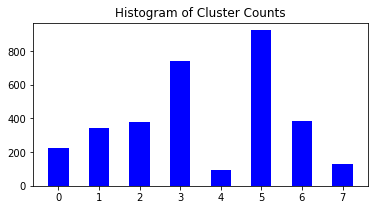

In [21]:
# another method of visualizing the distribution
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_info, bins=8,  range=(-0.5, 7.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

# Well
Well, we didn't really learn anything here so far. A more intuitive approach might be [this one](https://stackoverflow.com/a/34692511/7912879).

In [30]:
# PCA
n_components=8

pca = PCA(n_components=n_components)
pca.fit_transform(counties_scaled)

# Dump components relations with features:
df_pca = pd.DataFrame(pca.components_,
             columns=counties_scaled.columns,
             index = [f"PC-{i+1}" for i in range(n_components)])

df_pca.head(3)

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
PC-1,0.005046,0.004953,0.005136,0.392619,-0.601972,0.207529,0.038430,-0.004536,0.001652,0.004569,...,-0.004034,0.013728,-0.078116,0.054965,0.003422,-0.103600,0.141610,-0.063451,-0.014286,0.233627
PC-2,-0.015988,-0.015730,-0.016238,0.278088,-0.092912,-0.348800,0.113913,0.002377,0.014045,-0.019234,...,0.120834,0.039225,0.225706,-0.288411,-0.015866,-0.443173,0.232524,0.309406,0.070674,-0.120169
PC-3,0.076393,0.075959,0.076814,0.322116,-0.373134,0.001155,-0.038152,0.173815,0.018965,0.084550,...,-0.014532,0.012386,-0.009739,0.120439,0.079684,0.182156,-0.085712,-0.139890,-0.041734,-0.069706


In [34]:
df_pca.T.apply(lambda x: abs(x) > 0.1)

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8
TotalPop,False,False,False,False,False,False,False,False
Men,False,False,False,False,False,False,False,False
Women,False,False,False,False,False,False,False,False
Hispanic,True,True,True,True,True,False,True,True
White,True,False,True,True,True,True,False,False
Black,True,True,False,True,True,True,True,True
Native,False,True,False,True,True,False,True,True
Asian,False,False,True,False,False,False,True,True
Pacific,False,False,False,False,False,False,False,False
Citizen,False,False,False,False,False,False,False,False


# Conclusion
Here we applied a PCA and it was ok, since there was no categorical data involved.